In [1]:
# =========================================================
# Basic Libraries:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from IPython. display import clear_output
# =========================================================
# Machine Learning Libraries:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D
from keras.initializers import Constant
from tensorflow.keras.optimizers import Adam
# =========================================================
# NLP Libraries:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.util import ngrams
# =========================================================
# Collections Libraries:
from collections import defaultdict
from collections import  Counter
# =========================================================
# Text Libraries
import re
import gensim
import string
from tqdm import tqdm
plt.style.use('ggplot')

In [2]:
def read_data():
    train_data = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
    print("Train data imported successfully!!")
    print("-"*50)
    test_data = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")
    print("Test data imported successfully!!")
    return train_data , test_data

In [3]:
train_data , test_data = read_data()

Train data imported successfully!!
--------------------------------------------------
Test data imported successfully!!



<a class = "anchor"  id = "dtd"  >
    <div style="color:#00ADB5;
               display:fill;
               border-radius:5px;
               background-color:#393E46;
               font-size:20px;
               font-family:sans-serif;
               letter-spacing:0.5px">
            <p style="padding: 10px;
                  color:white;">
                <b> 3 ) Discovering the data:</b>
            </p>
    </div>
</a>


From the competition information our data is:
- **id:**  a unique identifier for each tweet
- **text:**  the text of the tweet
- **location:**  the location the tweet was sent from (may be blank)
- **keyword:**  a particular keyword from the tweet (may be blank)
- **target:**  in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)

Let's see the first 5 rows from the data:

In [4]:
train_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
test_data.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [6]:
# =============================================
# Feature types:
# =============================================

train_data.info()
print("-"*50)
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


From the information above we can see that:
- Id feature is not necessary for training so i will delete it.
- There are blanks values in keywords and Location features so i will process them as possible as i can.

In [7]:
# Dropping Id feature:
Test_Id = test_data.id # We saved it for submission.
train_data.drop(columns = ["id"] , inplace = True)
test_data.drop(columns = ["id"] , inplace = True)

In [8]:
# ==============================================================
# Missing Data:
# ==============================================================
print("Missed Data in train data:")
print(train_data.isnull().sum())
print("-" * 50)
print("Missed Data in test data:")
test_data.isnull().sum()

Missed Data in train data:
keyword       61
location    2533
text           0
target         0
dtype: int64
--------------------------------------------------
Missed Data in test data:


keyword       26
location    1105
text           0
dtype: int64

location feature has a lot of missed data !!

<a class = "anchor" id = "hf">
    <div style="color:#00ADB5;
           display:fill;
           border-radius:5px;
           background-color:#393E46;
           font-size:20px;
           font-family:sans-serif;
           letter-spacing:0.5px">
        <p style="padding: 10px;
              color:white;">
            <b> 4 ) Helper Functions:</b>
        </p>
</div>
</a>

##### In this section i will create some functions to help us in the next steps:






**1 ) get_corpus:**

This function takes a list of strings and returns a list of the words contained in the strings **(with duplicats)**.

In [9]:
def get_corpus(texts):
    corpus = []
    for text in texts:
        corpus.extend(word_tokenize(text))
    return corpus
texts = ["I love kaggle!!" , "Keep going you can do it." , "You are amazing"]
print(f"Example: {texts}")
print(f"corpus: {get_corpus(texts)}")

Example: ['I love kaggle!!', 'Keep going you can do it.', 'You are amazing']
corpus: ['I', 'love', 'kaggle', '!', '!', 'Keep', 'going', 'you', 'can', 'do', 'it', '.', 'You', 'are', 'amazing']


**2 ) Stop words:**


Stop words are a set of commonly used words in any language. For example, in English, “the”, “is” and “and”, would easily qualify as stop words. In NLP and text mining applications, **stop words are used to eliminate unimportant words, allowing applications to focus on the important words instead.**

In [10]:
def get_stop_words():
    return set(stopwords.words('english'))
    
def remove_stop_words(text):
    result = ""
    stop_words = get_stop_words()
    for word in get_corpus([text]):
        if word not in stop_words:
            result += word + " "
    return result.strip()

print(f"Example: {list(get_stop_words())[:10]}")
print("-" * 100)
example = "Kaggle is a treasure"
print(f"Example: {example}")
print(f"Without Stop words: {remove_stop_words(example)}")

Example: ['him', 'an', 'doesn', 'their', 've', "it's", 'it', 'if', "shouldn't", 'down']
----------------------------------------------------------------------------------------------------
Example: Kaggle is a treasure
Without Stop words: Kaggle treasure


**3 ) Punctuations**

punctuations like ( "," , "." , "!" , "?" , ... )is not useful for NLP Models so we are going to remove them when training.

In [11]:
def get_punctuation():
    return string.punctuation

def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

example = "\"Trust yourself that you can do it and get it !!!\""
print(f"English language has many punctuations like: {get_punctuation()}")
print("-" * 100)
print(f"Example: {example}")
print(f"without punctuations: {remove_punct(example)}")

English language has many punctuations like: !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
----------------------------------------------------------------------------------------------------
Example: "Trust yourself that you can do it and get it !!!"
without punctuations: Trust yourself that you can do it and get it 


**4 ) lowecase texts:**

Your model might treat a word which is in the beginning of a sentence with a capital letter different from the same word which appears later in the sentence but without any capital latter, This might lead to decline in the accuracy. **get_lowercase()** function take a list of texts and return list of lowercase texts.

In [12]:
def get_lowercase(texts):
    lowercase_texts = []
    for text in texts:
        lowercase_texts.append(text.lower())
    return lowercase_texts

texts = ["I loVe kAGgle!!" , "KeeP goinG you can dO iT." , "BE YouR SelF"]
print(f"Example: {texts}")
print(f"lowercase: {get_lowercase(texts)}")

Example: ['I loVe kAGgle!!', 'KeeP goinG you can dO iT.', 'BE YouR SelF']
lowercase: ['i love kaggle!!', 'keep going you can do it.', 'be your self']


**5 ) remove urls:**

urls don't have any useful information and they are bad when training the model. 

In [13]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

example = "www.kaggle.com is the key to success, you can login from here https://www.kaggle.com"
print(f"Example: {example}")
print(f"without urls : {remove_URL(example)}")

Example: www.kaggle.com is the key to success, you can login from here https://www.kaggle.com
without urls :  is the key to success, you can login from here 


**6 ) Removing Html tags:**

In [14]:
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

example = """
<div>
<h1>Kaggle is here</h1>
<p>You can success</p>
<a href="https://www.kaggle.com/">click me</a>
</div>"""
print(f"Example: {example}")
print("-" * 100)
print(f"without Html tags: {remove_html(example)}")

Example: 
<div>
<h1>Kaggle is here</h1>
<p>You can success</p>
<a href="https://www.kaggle.com/">click me</a>
</div>
----------------------------------------------------------------------------------------------------
without Html tags: 

Kaggle is here
You can success
click me



**7 ) Removing Emojies:**

In [15]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

example = "If you can dream it, you can do it 💪🖤"
print(f"Examples : {example}")
print(f"without emojies: {remove_emoji(example)}")


Examples : If you can dream it, you can do it 💪🖤
without emojies: If you can dream it, you can do it 


**8 ) correct spelling:**

In [16]:
!pip install pyspellchecker
clear_output()

In [17]:
from spellchecker import SpellChecker

spell = SpellChecker()
def correct_spellings(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)
        
text = "Do th qest you canp"
correct_spellings(text)

'Do the best you can'

In [18]:
# =======================================================================
# Before starting, I will change all tweets by lowercase tweets:
# =======================================================================
train_data["text"] = get_lowercase(train_data["text"])
test_data["text"] = get_lowercase(test_data["text"])
print("Done !")

Done !


Now we are ready to start with EDA Step !!

<a class = "anchor" id = "eda">
    <div style="color:#00ADB5;
           display:fill;
           border-radius:5px;
           background-color:#393E46;
           font-size:20px;
           font-family:sans-serif;
           letter-spacing:0.5px">
        <p style="padding: 10px;
              color:white;">
            <b> 5 ) Exploratory Data Analysis (EDA):</b>
        </p>
</div>
</a>






<a class = "anchor" id = target >
    <div style="color:black;
               border-radius:0px;
               background-color:#00ADB5;
               font-size:14px;
               font-family:sans-serif;
               letter-spacing:0.5px">
            <p style="padding: 6px;
                  color:white;">
                <b>Target:</b>
            </p>
    </div>
</a>


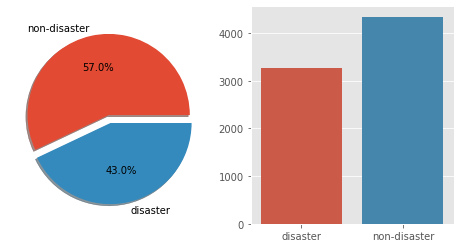

In [19]:
# ===================================================================
# Count of disaster and non-disaster tweets:
# ===================================================================
f,ax=plt.subplots(1,2,figsize=(8,4))
train_data['target'].replace({0:"non-disaster",1:"disaster"}).value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_ylabel('')
sns.countplot(x = train_data["target"].replace({0:"non-disaster",1:"disaster"}) , ax = ax[1])
ax[1].set_ylabel('')
ax[1].set_xlabel('')
plt.show()

non-disaster tweets are more than disaster tweets.

<a class = "anchor" id = num_ch >
    <div style="color:black;
               border-radius:0px;
               background-color:#00ADB5;
               font-size:14px;
               font-family:sans-serif;
               letter-spacing:0.5px">
            <p style="padding: 6px;
                  color:white;">
                <b>Number of charecters of tweets:</b>
            </p>
    </div>
</a>


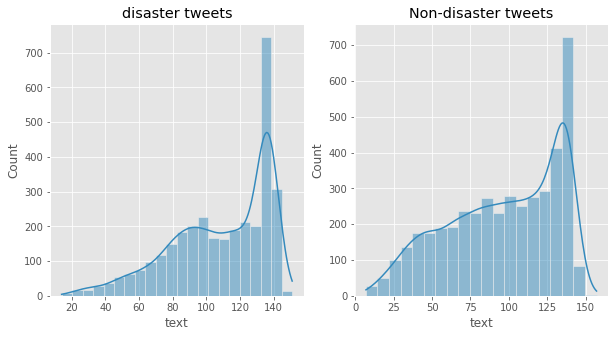

In [20]:
fig,ax=plt.subplots(1,2,figsize=(10,5))
tweet_len=train_data[train_data['target']==1]['text'].str.len()
sns.histplot(tweet_len ,kde = True , ax = ax[0]).set_title("disaster tweets")
tweet_len=train_data[train_data['target']==0]['text'].str.len()
sns.histplot(tweet_len , kde = True ,ax = ax[1]).set_title("Non-disaster tweets")
plt.show()

From the plots above we can see that the most common length of disaster and non-disaster tweets are from 120 to 140 characters


<a class = "anchor" id = num_wr >
    <div style="color:black;
               border-radius:0px;
               background-color:#00ADB5;
               font-size:14px;
               font-family:sans-serif;
               letter-spacing:0.5px">
            <p style="padding: 6px;
                  color:white;">
                <b>Number of words of tweets:</b>
            </p>
    </div>
</a>


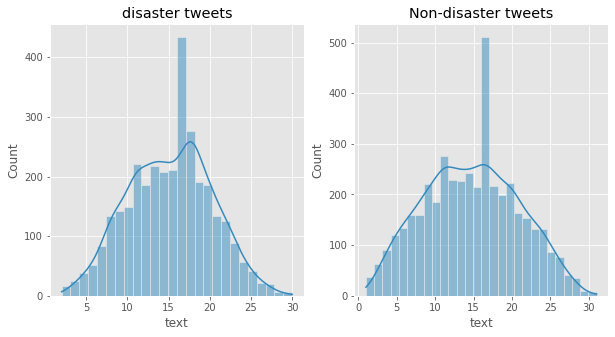

In [21]:
fig,ax=plt.subplots(1,2,figsize=(10,5))
tweet_len=train_data[train_data['target']==1]['text'].str.split().map(lambda x: len(x))
sns.histplot(tweet_len ,kde = True , ax = ax[0]).set_title("disaster tweets")
tweet_len=train_data[train_data['target']==0]['text'].str.split().map(lambda x: len(x))
sns.histplot(tweet_len , kde = True ,ax = ax[1]).set_title("Non-disaster tweets")
plt.show()

words count for disaster and non-disaster tweets are approximately similar.

<a class = "anchor" id = len_wr >
    <div style="color:black;
               border-radius:0px;
               background-color:#00ADB5;
               font-size:14px;
               font-family:sans-serif;
               letter-spacing:0.5px">
            <p style="padding: 6px;
                  color:white;">
                <b>Average word length in a tweet:</b>
            </p>
    </div>
</a>


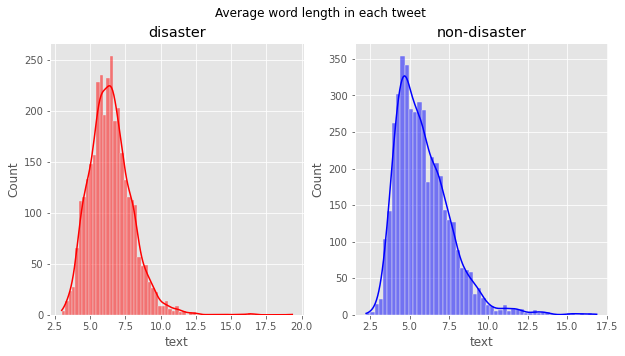

Average word lengths for disaster tweets: 6.469866063188727 with standard deviation 1.5167055641679672
Average word lengths for non-disaster tweets: 5.871324779540672 with standard deviation 1.7419493133031982


In [22]:
fig,ax=plt.subplots(1,2,figsize=(10,5))
word_len=train_data[train_data['target']==1]['text'].str.split().apply(lambda x : [len(i) for i in x])
word_len_avg_disaster = word_len.map(lambda x: np.mean(x))
sns.histplot(word_len_avg_disaster,ax=ax[0],color='red' , kde = True).set_title("disaster")
word_len=train_data[train_data['target']==0]['text'].str.split().apply(lambda x : [len(i) for i in x])
word_len_avg_non_disaster = word_len.map(lambda x: np.mean(x))
sns.histplot(word_len_avg_non_disaster,ax=ax[1],color='blue', kde = True).set_title("non-disaster")
fig.suptitle('Average word length in each tweet')
plt.show()
print(f"Average word lengths for disaster tweets: {np.mean(word_len_avg_disaster)} with standard deviation {np.std(word_len_avg_disaster)}")
print(f"Average word lengths for non-disaster tweets: {np.mean(word_len_avg_non_disaster)} with standard deviation {np.std(word_len_avg_non_disaster)}")

most common word lengths for non-disaster tweets are less than word lengths of non-disaster tweets

<a class = "anchor" id = sw >
    <div style="color:black;
               border-radius:0px;
               background-color:#00ADB5;
               font-size:14px;
               font-family:sans-serif;
               letter-spacing:0.5px">
            <p style="padding: 6px;
                  color:white;">
                <b>Stopwords, punctuations:</b>
            </p>
    </div>
</a>


In [23]:
# disaster and non-disaster tweet corpuses:
corpus_disaster = get_corpus(train_data[train_data["target"] == 1]["text"])
corpus_non_disaster = get_corpus(train_data[train_data["target"] == 0]["text"])

Text(0.5, 0.98, 'Stop words in disaster Vs non-disaster tweets')

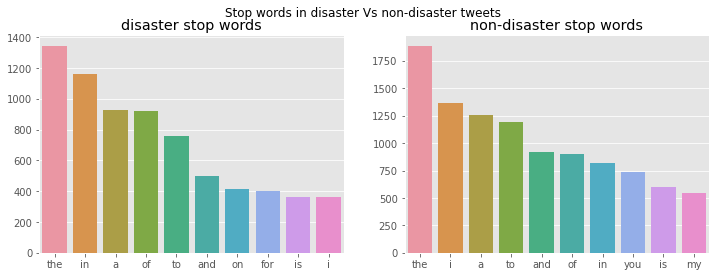

In [24]:
# =====================================================================
# STOPWORDS:
# =====================================================================
# getting english stop words ..
eng_stop_words = get_stop_words()
# =====================================================================
# disaster tweet stop words:
stop_words_dic=defaultdict(int)
for word in corpus_disaster:
    if word in eng_stop_words:
        stop_words_dic[word]+=1

fig , ax = plt.subplots(1 , 2 , figsize = (12 , 4))
top=sorted(stop_words_dic.items(), key=lambda x:x[1],reverse=True)[:10] 
x,y=zip(*top)
sns.barplot(x = list(x), y = list(y), ax = ax[0]).set_title("disaster stop words")
# =====================================================================
# non-disaster tweet stop words:
stop_words_dic=defaultdict(int)

for word in corpus_non_disaster:
    if word in eng_stop_words:
        stop_words_dic[word]+=1

top=sorted(stop_words_dic.items(), key=lambda x:x[1],reverse=True)[:10] 
x,y=zip(*top)
sns.barplot(x = list(x), y = list(y), ax = ax[1]).set_title("non-disaster stop words")
fig.suptitle('Stop words in disaster Vs non-disaster tweets')

disaster tweets have more "in" word than non_disaster tweets 

Text(0.5, 0.98, 'Punctuations in disaster Vs non-disaster tweets')

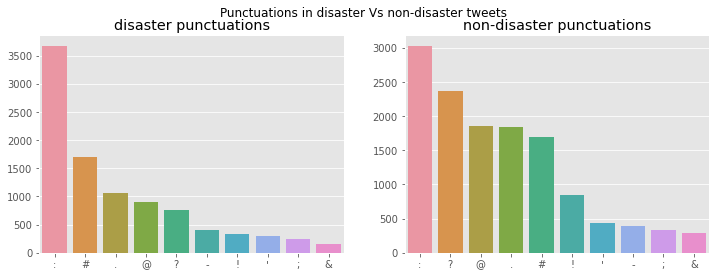

In [25]:
# =====================================================================
# PUNCTUATIONS:
# =====================================================================
# getting english punctuations:
eng_puncs = get_punctuation()
# =====================================================================
# disaster tweet stop words:
puncs_dic=defaultdict(int)
for word in corpus_disaster:
    if word in eng_puncs:
        puncs_dic[word]+=1

fig , ax = plt.subplots(1 , 2 , figsize = (12 , 4))
top=sorted(puncs_dic.items(), key=lambda x:x[1],reverse=True)[:10] 
x,y=zip(*top)
sns.barplot(x = list(x), y = list(y), ax = ax[0]).set_title("disaster punctuations")
# =====================================================================
# non-disaster tweet stop words:
puncs_dic=defaultdict(int)
for word in corpus_non_disaster:
    if word in eng_puncs:
        puncs_dic[word]+=1

top=sorted(puncs_dic.items(), key=lambda x:x[1],reverse=True)[:10] 
x,y=zip(*top)
sns.barplot(x = list(x), y = list(y), ax = ax[1]).set_title("non-disaster punctuations")
fig.suptitle('Punctuations in disaster Vs non-disaster tweets')


<a class = "anchor" id = mcw >
    <div style="color:black;
               border-radius:0px;
               background-color:#00ADB5;
               font-size:14px;
               font-family:sans-serif;
               letter-spacing:0.5px">
            <p style="padding: 6px;
                  color:white;">
                <b>Most Common Words:</b>
            </p>
    </div>
</a>


Text(0.5, 1.0, 'Non-Disaster tweet most common words')

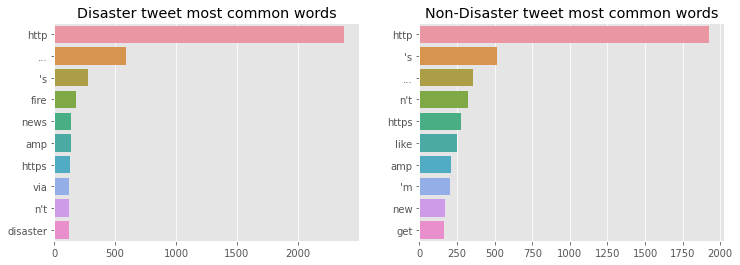

In [26]:
# ===============================================
# Disaster most common words:
counter=Counter(corpus_disaster)
most=counter.most_common()
words=[]
freq=[]
for word,count in most:
    if (word not in eng_stop_words) and (word not in eng_puncs) :
        words.append(word)
        freq.append(count)

fig , ax = plt.subplots(1 , 2 , figsize = (12,4) )
sns.barplot(x = freq[:10] , y = words[:10] , ax = ax[0]).set_title("Disaster tweet most common words")
# ===============================================
# Non-Disaster most common words:

counter=Counter(corpus_non_disaster)
most=counter.most_common()
words=[]
freq=[]
for word,count in most:
    if (word not in eng_stop_words) and (word not in eng_puncs) :
        words.append(word)
        freq.append(count)

sns.barplot(x = freq[:10] , y = words[:10] , ax = ax[1]).set_title("Non-Disaster tweet most common words")


We have a lot of data cleaning !!

<a class = "anchor" id = ngram >
    <div style="color:black;
               border-radius:0px;
               background-color:#00ADB5;
               font-size:14px;
               font-family:sans-serif;
               letter-spacing:0.5px">
            <p style="padding: 6px;
                  color:white;">
                <b>Ngram Analysis:</b>
            </p>
    </div>
</a>


In [27]:
def get_top_tweet_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

<AxesSubplot:>

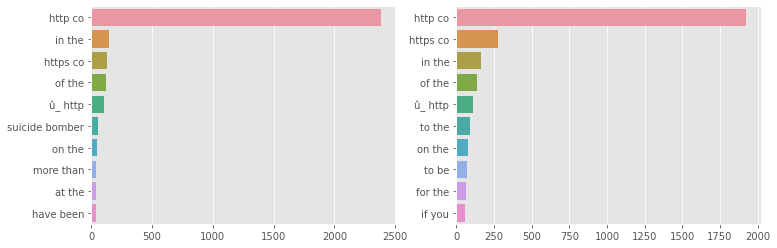

In [28]:
fig , ax = plt.subplots(1 , 2 , figsize=(12,4))
top_tweet_bigrams_disaster=get_top_tweet_bigrams(train_data[train_data["target"] == 1]['text'])[:10]
top_tweet_bigrams_non_disaster=get_top_tweet_bigrams(train_data[train_data["target"] == 0]['text'])[:10]
x,y=map(list,zip(*top_tweet_bigrams_disaster))
sns.barplot(x=y,y=x , ax = ax[0])
x,y=map(list,zip(*top_tweet_bigrams_non_disaster))
sns.barplot(x=y,y=x , ax = ax[1])

We have a lot of data cleaning Again ^-^ !!

<a class = "anchor" id = "dc">
    <div style="color:#00ADB5;
           display:fill;
           border-radius:5px;
           background-color:#393E46;
           font-size:20px;
           font-family:sans-serif;
           letter-spacing:0.5px">
        <p style="padding: 10px;
              color:white;">
            <b> 6 ) Data Cleaning:</b>
        </p>
</div>
</a>






First of all we are going to merge training and testing data to apply data cleaning on them together.

In [29]:
target = train_data["target"] # save the target for training step.
all_data = pd.concat([train_data,test_data]).reset_index(drop = True)
all_data.drop(columns = ["target"] , inplace = True)
all_data.head()

,keyword,location,text
0,NaN,NaN,our deeds are the reason of this #earthquake m...
1,NaN,NaN,forest fire near la ronge sask. canada
2,NaN,NaN,all residents asked to 'shelter in place' are ...
3,NaN,NaN,"13,000 people receive #wildfires evacuation or..."
4,NaN,NaN,just got sent this photo from ruby #alaska as ...


This DataFrame contain all data (training and testing)

<a class = "anchor" id = rm_urls >
    <div style="color:black;
               border-radius:0px;
               background-color:#00ADB5;
               font-size:14px;
               font-family:sans-serif;
               letter-spacing:0.5px">
            <p style="padding: 6px;
                  color:white;">
                <b>Removing urls:</b>
            </p>
    </div>
</a>


In [30]:
all_data['text']=all_data['text'].apply(lambda x : remove_URL(x))

<a class = "anchor" id = rm_html >
    <div style="color:black;
               border-radius:0px;
               background-color:#00ADB5;
               font-size:14px;
               font-family:sans-serif;
               letter-spacing:0.5px">
            <p style="padding: 6px;
                  color:white;">
                <b>Removing Html tags:</b>
            </p>
    </div>
</a>


In [31]:
all_data['text']=all_data['text'].apply(lambda x : remove_html(x))

<a class = "anchor" id = rm_emojies >
    <div style="color:black;
               border-radius:0px;
               background-color:#00ADB5;
               font-size:14px;
               font-family:sans-serif;
               letter-spacing:0.5px">
            <p style="padding: 6px;
                  color:white;">
                <b>Removing Emojies:</b>
            </p>
    </div>
</a>


In [32]:
all_data['text']=all_data['text'].apply(lambda x : remove_emoji(x))

<a class = "anchor" id = rm_puncs >
    <div style="color:black;
               border-radius:0px;
               background-color:#00ADB5;
               font-size:14px;
               font-family:sans-serif;
               letter-spacing:0.5px">
            <p style="padding: 6px;
                  color:white;">
                <b>Removing Punctuations:</b>
            </p>
    </div>
</a>


In [33]:
all_data['text']=all_data['text'].apply(lambda x : remove_punct(x))

<a class = "anchor" id = rm_sw >
    <div style="color:black;
               border-radius:0px;
               background-color:#00ADB5;
               font-size:14px;
               font-family:sans-serif;
               letter-spacing:0.5px">
            <p style="padding: 6px;
                  color:white;">
                <b>Removing Stopwords:</b>
            </p>
    </div>
</a>


In [34]:
all_data['text']=all_data['text'].apply(lambda x : remove_stop_words(x))

<a class = "anchor" id = cor_sp >
    <div style="color:black;
               border-radius:0px;
               background-color:#00ADB5;
               font-size:14px;
               font-family:sans-serif;
               letter-spacing:0.5px">
            <p style="padding: 6px;
                  color:white;">
                <b>Correct Spelling:</b>
            </p>
    </div>
</a>


this cell may take around 30 mins i will run it later.

In [35]:
# import os
# corrected = 0
# for tweet in all_data["text"]:
#     tweet = correct_spellings(tweet)
#     corrected += 1
#     print(f"{corrected} from {all_data.shape[0]} tweets are corrected!", end='\r')

In [36]:
all_data.head()

,keyword,location,text
0,NaN,NaN,deeds reason earthquake may allah forgive us
1,NaN,NaN,forest fire near la ronge sask canada
2,NaN,NaN,residents asked shelter place notified officer...
3,NaN,NaN,13000 people receive wildfires evacuation orde...
4,NaN,NaN,got sent photo ruby alaska smoke wildfires pou...


<a class="anchor" id="modeling">
    <div style="color:#00ADB5;
               display:fill;
               border-radius:5px;
               background-color:#393E46;
               font-size:20px;
               font-family:sans-serif;
               letter-spacing:0.5px">
            <p style="padding: 10px;
                  color:white;">
                <b>7 ) Modeling:</b>
            </p>
    </div>
</a>

<a class = "anchor" id = tv >
    <div style="color:black;
               border-radius:0px;
               background-color:#00ADB5;
               font-size:14px;
               font-family:sans-serif;
               letter-spacing:0.5px">
            <p style="padding: 6px;
                  color:white;">
                <b>Text Vectorization:</b>
            </p>
    </div>
</a>


Processing natural language text and extract useful information from the given word, a sentence using machine learning and deep learning techniques requires the string/text needs to be converted into a set of **real numbers (a vector) — Word Embeddings.**

**Word Embeddings or Word vectorization:** is a methodology in NLP to map words or phrases from vocabulary to a corresponding vector of real numbers which used to find word predictions, word similarities/semantics.

#### Vectorization techniques:
1. Bag of Words
2. TF-IDF
3. Word2Vec
4. GloVe
5. FastText


You can see a full comparison of these methods from [here](https://neptune.ai/blog/vectorization-techniques-in-nlp-guide#:~:text=Vectorization%20is%20jargon%20for%20a,format%20that%20ML%20models%20support.). I will use **GloVe** technique. It is available in 4 varieties :50D ,100D, 200D, 300D Dimentional.We will try 100 D here.

In [37]:
# Downloading GloVe (You can skip this cell):
import os
os.chdir(r'/kaggle/working')    
# downloading Glove
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove*.zip -d /kaggle/working/GloVe
!rm glove*.zip
clear_output()

In [38]:
# Filling embedding_dict with pairs of word and its vector from GloVe file (There are an example below).
embedding_dict={}
with open('/kaggle/working/GloVe/glove.6B.100d.txt','r') as f:
    for line in f:
        values=line.split()
        word=values[0]
        vectors=np.asarray(values[1:],'float32')
        embedding_dict[word]=vectors
f.close()

In [39]:
# GloVe Example:
the_word_code = embedding_dict["the"]
disaster_word_code = embedding_dict["disaster"]
print(f"Code of \"the\" word is {the_word_code[:5]} ... (100 numbers)")
print(f"Code of \"disaster\" word is {disaster_word_code[:5]} ... (100 numbers)")

Code of "the" word is [-0.038194 -0.24487   0.72812  -0.39961   0.083172] ... (100 numbers)
Code of "disaster" word is [-0.28035  0.64791  0.54977 -0.10451 -0.27355] ... (100 numbers)


<center><img src = "https://miro.medium.com/max/530/1*LdviucnshWgIIcQvhTTF-g.png" width = "500"></center>
<center>"an example of representing words in a Space"</center>

**1 ) Getting corpus for each tweet:**

Now we want to extract the words from each tweet in all_data (There are an example below)

In [40]:
# Getting corpus for each tweet:
all_data_corpus = []
for index , tweet in all_data.iterrows():
    all_data_corpus.append(get_corpus([tweet["text"]]))
print("Corpus for first 2 tweets are")
all_data_corpus[:2]

Corpus for first 2 tweets are


[['deeds', 'reason', 'earthquake', 'may', 'allah', 'forgive', 'us'],
 ['forest', 'fire', 'near', 'la', 'ronge', 'sask', 'canada']]

**2 ) Tokenizing words of each tweet :**  

In this step we are going to assign each word to a unique number.

In [41]:
tokenizer_obj=Tokenizer()
tokenizer_obj.fit_on_texts(all_data_corpus)
word_index=tokenizer_obj.word_index
print(f"There are {len(word_index)} unique words")
print("Let's see first 5 words:")
list(word_index.items())[:5]

There are 22671 unique words
Let's see first 5 words:


[('like', 1), ('amp', 2), ('im', 3), ('fire', 4), ('get', 5)]

In [42]:
MAX_LEN=50
sequences=tokenizer_obj.texts_to_sequences(all_data_corpus)
tweet_pad=pad_sequences(sequences,maxlen=MAX_LEN,truncating='post',padding='post')
print("first 2 tweets after tokenizing without padding are:")
print(sequences[0])
print(sequences[1])
print("-" * 100)
print("first 2 tweets after tokenizing and padding are:")
print(tweet_pad[0])
print(tweet_pad[1])

first 2 tweets after tokenizing without padding are:
[5649, 704, 150, 65, 1784, 3577, 12]
[79, 4, 118, 705, 8372, 8373, 1280]
----------------------------------------------------------------------------------------------------
first 2 tweets after tokenizing and padding are:
[5649  704  150   65 1784 3577   12    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]
[  79    4  118  705 8372 8373 1280    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]


**3 ) Creating the embedding matrix:**

This matrix contains count of rows equal to **count of our unique words** and **100** columns (GloVe vectors).

In [43]:
num_words=len(word_index)+1
embedding_matrix=np.zeros((num_words,100))
for word,i in tqdm(word_index.items()):
    emb_vec=embedding_dict.get(word)
    if emb_vec is not None:
        embedding_matrix[i]=emb_vec

100%|██████████| 22671/22671 [00:00<00:00, 288929.67it/s]


In [44]:
print("first 2 rows of embedding matrix are:")
print(embedding_matrix[1:3])

first 2 rows of embedding matrix are:
[[-0.2687      0.81708002  0.69896001 -0.72341001  0.091566    0.19557001
  -0.52112001 -0.24313    -0.44701001 -0.27039    -0.34125999 -0.46898001
   0.42583001  0.46289     0.17106    -0.26795     0.23162     0.46568
  -0.31808001  0.75875002  0.31856999  0.64124     0.067042   -0.18516999
   0.49996001  0.36963999 -0.31172001 -0.73097998 -0.26901999 -0.32058001
   0.23394001  0.24276     0.1426     -0.2793      0.38823     0.42398
   0.1021      0.33316001  0.30149999 -0.52710998 -0.024475   -0.15301
  -0.3224     -0.51231003 -0.55250001  0.29819     0.10847     0.052334
  -0.2298     -0.77889001 -0.08928     0.48109001  0.015368    0.92544001
  -0.26122001 -2.47589993 -0.019825    0.58280998  1.30599999  0.73512
  -0.34371999  1.58290005 -0.10814     0.11388     0.79220003  0.18347
   1.22319996  0.35697001  0.17504001 -0.16527    -0.012827   -0.47918001
  -0.32111001 -0.40573001 -0.37151     0.086323    0.25172001 -0.082751
  -0.25584    -0.19

<a class = "anchor" id = blm >
    <div style="color:black;
               border-radius:0px;
               background-color:#00ADB5;
               font-size:14px;
               font-family:sans-serif;
               letter-spacing:0.5px">
            <p style="padding: 6px;
                  color:white;">
                <b>Baseline Model:</b>
            </p>
    </div>
</a>


In [45]:
model=Sequential()

embedding=Embedding(num_words,100,embeddings_initializer=Constant(embedding_matrix),
                   input_length=MAX_LEN,trainable=False)

model.add(embedding)
model.add(SpatialDropout1D(0.2))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))


optimzer=Adam(learning_rate=1e-5)

model.compile(loss='binary_crossentropy',optimizer=optimzer,metrics=['accuracy'])

clear_output()

In [46]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 100)           2267200   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 50, 100)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                42240     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 2,309,505
Trainable params: 42,305
Non-trainable params: 2,267,200
_________________________________________________________________


In [47]:
train=tweet_pad[:train_data.shape[0]]
test=tweet_pad[train_data.shape[0]:]

In [48]:
X_train,X_test,y_train,y_test=train_test_split(train,target,test_size=0.15)
print('Shape of train',X_train.shape)
print("Shape of Validation ",X_test.shape)

Shape of train (6471, 50)
Shape of Validation  (1142, 50)


In [49]:
history=model.fit(X_train,y_train,batch_size=16,epochs=15,validation_data=(X_test,y_test),verbose=1)

Epoch 1/15


2022-08-18 15:05:32.492746: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


405/405 [==============================] - 132s 315ms/step - loss: 0.6922 - accuracy: 0.5702 - val_loss: 0.6914 - val_accuracy: 0.5639
Epoch 2/15
405/405 [==============================] - 128s 316ms/step - loss: 0.6886 - accuracy: 0.5715 - val_loss: 0.6824 - val_accuracy: 0.5639
Epoch 3/15
405/405 [==============================] - 127s 313ms/step - loss: 0.6271 - accuracy: 0.6528 - val_loss: 0.5691 - val_accuracy: 0.7531
Epoch 4/15
405/405 [==============================] - 128s 316ms/step - loss: 0.5616 - accuracy: 0.7456 - val_loss: 0.5411 - val_accuracy: 0.7741
Epoch 5/15
405/405 [==============================] - 128s 317ms/step - loss: 0.5427 - accuracy: 0.7507 - val_loss: 0.5259 - val_accuracy: 0.7793
Epoch 6/15
405/405 [==============================] - 127s 313ms/step - loss: 0.5320 - accuracy: 0.7558 - val_loss: 0.5156 - val_accuracy: 0.7767
Epoch 7/15
405/405 [==============================] - 127s 315ms/step - loss: 0.5208 - accuracy: 0.7650 - val_loss: 0.5077 - val_accura

<AxesSubplot:>

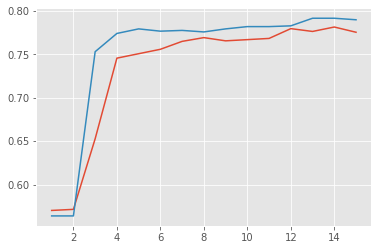

In [50]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1 , len(acc)+1)

sns.lineplot(x = epochs , y = acc)
sns.lineplot(x = epochs , y = val_acc)

<a class = "anchor" id = sub >
    <div style="color:black;
               border-radius:0px;
               background-color:#00ADB5;
               font-size:14px;
               font-family:sans-serif;
               letter-spacing:0.5px">
            <p style="padding: 6px;
                  color:white;">
                <b>Making our submission:</b>
            </p>
    </div>
</a>


In [51]:
sample_sub=pd.read_csv('../input/nlp-getting-started/sample_submission.csv')

In [52]:
y_pre=model.predict(test)
y_pre=np.round(y_pre).astype(int).reshape(3263)
sub=pd.DataFrame({'id':sample_sub['id'].values.tolist(),'target':y_pre})
sub.to_csv('submission.csv',index=False)